In [1]:
# import libraries
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras import layers
from keras.layers.experimental.preprocessing import TextVectorization
from keras.preprocessing import sequence


In [2]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"


--2023-12-11 04:18:24--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 104.26.2.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358233 (350K) [text/tab-separated-values]
Saving to: ‘train-data.tsv’

train-data.tsv      100%[===================>] 349.84K   957KB/s    in 0.4s    

2023-12-11 04:18:25 (957 KB/s) - ‘train-data.tsv’ saved [358233/358233]

--2023-12-11 04:18:25--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 104.26.2.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118774 (116K) [text/tab-separated-values]
Saving to: ‘valid-data.tsv’

valid-data.tsv      100%[===============

In [3]:
# train dataframe
df_train = pd.read_csv(train_file_path, sep="\t", header=None, names=["type", "msg"])
df_train.dropna()
df_train.head(2)


,type,msg
0,ham,ahhhh...just woken up!had a bad dream about u ...
1,ham,you can never do nothing


In [4]:
# test dataframe
df_test = pd.read_csv(test_file_path, sep="\t", header=None, names=["type", "msg"])
df_test.dropna()
df_test.head(2)


,type,msg
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"


In [5]:
# define labels
df_train["type"] = pd.factorize(df_train["type"])[0]
df_test["type"] = pd.factorize(df_test["type"])[0]
print(df_train.head(2))
print(df_test.head(2))


   type                                                msg
0     0  ahhhh...just woken up!had a bad dream about u ...
1     0                           you can never do nothing
   type                                                msg
0     0  i am in hospital da. . i will return home in e...
1     0         not much, just some textin'. how bout you?


In [6]:
# create train tensor
labels_train =  df_train["type"].values
ds_train = tf.data.Dataset.from_tensor_slices(
    (df_train["msg"].values, labels_train)
)


In [7]:
# create test tensor
labels_test =  df_test["type"].values
ds_test = tf.data.Dataset.from_tensor_slices(
    (df_test["msg"].values, labels_test)
)


In [8]:
# set parameters
BUFFER_SIZE = 100
BATCH_SIZE = 32
ds_train = ds_train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [9]:
# configure vectorization
vec = TextVectorization(
    output_mode='int',
    max_tokens=1000,
    output_sequence_length=1000,
)

vec.adapt(ds_train.map(lambda text, label: text))
vocab = np.array(vec.get_vocabulary())
vocab[:20]


array(['', '[UNK]', 'to', 'i', 'you', 'a', 'the', 'u', 'and', 'in', 'is',
       'me', 'my', 'for', 'your', 'of', 'it', 'call', 'have', 'on'],
      dtype='<U15')

In [10]:
# build the model
model = tf.keras.Sequential([
    vec,
    layers.Embedding(
        input_dim=len(vec.get_vocabulary()),
        output_dim=128,
        mask_zero=True,
    ),
    layers.Bidirectional(layers.LSTM(128, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(64)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])


model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=['accuracy'],
)


In [11]:
# train the model
history = model.fit(
    ds_train,
    validation_data=ds_test,
    validation_steps=30,
    epochs=10,
)


Epoch 1/10
131/131 [==============================] - 66s 280ms/step - loss: 0.1902 - accuracy: 0.9442 - val_loss: 0.0635 - val_accuracy: 0.9792
Epoch 2/10
131/131 [==============================] - 25s 195ms/step - loss: 0.0449 - accuracy: 0.9873 - val_loss: 0.0569 - val_accuracy: 0.9781
Epoch 3/10
131/131 [==============================] - 26s 198ms/step - loss: 0.0229 - accuracy: 0.9931 - val_loss: 0.0603 - val_accuracy: 0.9823
Epoch 4/10
131/131 [==============================] - 25s 191ms/step - loss: 0.0362 - accuracy: 0.9923 - val_loss: 0.0570 - val_accuracy: 0.9833
Epoch 5/10
131/131 [==============================] - 24s 186ms/step - loss: 0.0146 - accuracy: 0.9943 - val_loss: 0.0721 - val_accuracy: 0.9823
Epoch 6/10
131/131 [==============================] - 24s 182ms/step - loss: 0.0126 - accuracy: 0.9964 - val_loss: 0.0829 - val_accuracy: 0.9781
Epoch 7/10
131/131 [==============================] - 24s 187ms/step - loss: 0.0085 - accuracy: 0.9974 - val_loss: 0.0840 - val_ac

44/44 [==============================] - 1s 15ms/step - loss: 0.1456 - accuracy: 0.9842
Test Loss: 0.14557094871997833
Test Accuracy: 0.9841954112052917


(0.0, 0.1995962189277634)

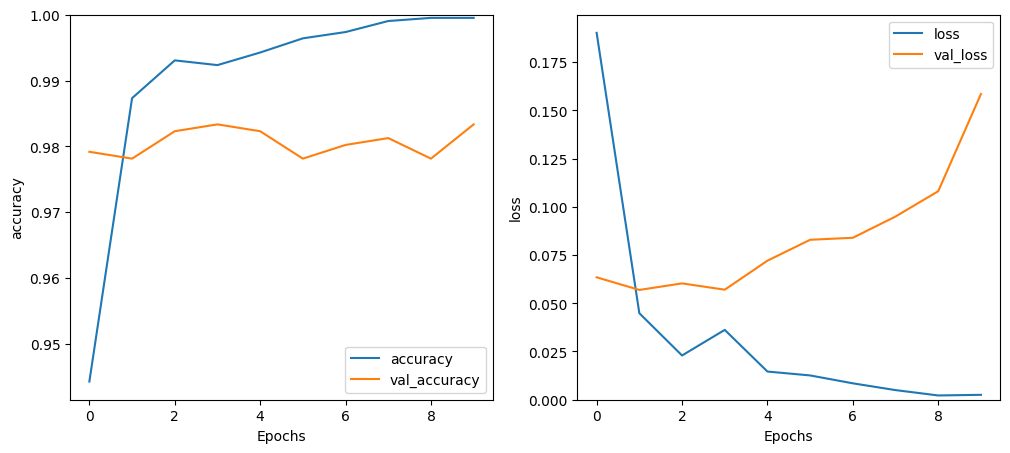

In [12]:
# plot accuracy
test_loss, test_acc = model.evaluate(ds_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

def plot_graphs(h, metric):
    plt.plot(h.history[metric])
    plt.plot(h.history['val_'+metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)


In [13]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
    ps = model.predict([pred_text])
    print(ps)
    p = ps[0][0]
    return [p, "ham" if p <0.5 else "spam"]

pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)


1/1 [==============================] - 5s 5s/step
[[-15.476717]]
[-15.476717, 'ham']


In [14]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460 4",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)

    if prediction[1] != ans:
      passed = False
      print(prediction)

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()

1/1 [==============================] - 0s 38ms/step
[[-15.476717]]
1/1 [==============================] - 0s 37ms/step
[[16.360003]]
1/1 [==============================] - 0s 46ms/step
[[-17.928745]]
1/1 [==============================] - 0s 43ms/step
[[20.511335]]
1/1 [==============================] - 0s 41ms/step
[[19.724703]]
1/1 [==============================] - 0s 37ms/step
[[-15.535944]]
1/1 [==============================] - 0s 37ms/step
[[-17.121992]]
You passed the challenge. Great job!
